# Importación de Bibliotecas

In [17]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from scipy.sparse import csr_matrix
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV


# Carga de datos y Preprocesamiento

Importamos el dataset de entrenamiento

In [2]:
df = pd.read_csv("./train_normalizado_lematizacion.csv")

ds_trabajo = df.copy()
ds_trabajo.head(5)

,ID,review_es,sentimiento
0,0,uno de el otro crítico haber mencionar que des...,positivo
1,1,uno pequeño pequeño producción el técnica de f...,positivo
2,2,pensar que este ser uno manera maravilloso de ...,positivo
3,3,básicamente haber uno familia donde uno niño...,negativo
4,4,el amor en el tiempo de petter mattei ser ...,positivo


Creamos una función para mostrar las métricas y la matriz de confusión de nuestras predicciones.

In [3]:
def mostrar_metricas(y_test, y_pred):
    print("La accuracy es {}".format(accuracy_score(y_test, y_pred)))
    print("La precision es {}".format(precision_score(y_test, y_pred, average='macro')))
    print("El recall es {}".format(recall_score(y_test, y_pred, average='macro')))
    print("El F1 es {}".format(f1_score(y_test, y_pred, average='macro')))

    cm = confusion_matrix(y_test,y_pred)
    sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
    plt.xlabel('Valores Predicción')
    plt.ylabel('Valores Reales')

Obtenemos las stopwords en español de la bibliotecta nltk para eliminarlas de los textos posteriormente.

In [4]:
stopwords = nltk.corpus.stopwords.words('spanish')

Vamos a aplicar las técnicas de lemmatización y stemming para reducir la cantidad y la complejidad de las palabras en los textos, generando dos datasets distintos con estos preprocesamientos para utilizar a lo largo del trabajo. 

Nota: vamos a dejar los preprocesamientos aplicados comentados y los guardaremos en los csv `train_normalizado_lematizacion.csv` y `train_normalizado_stemming.csv`. Vamos a hacer lo mismo para `test.csv`.

In [ ]:
## Aplicamos lemmatizacion
# import re
# ds_trabajo.review_es = ds_trabajo.review_es.str.lower();
# ds_trabajo.review_es = ds_trabajo.review_es.apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
# ds_trabajo.review_es

In [ ]:
# nlp = spacy.load('es_core_news_sm')

# # Realizar la lematización en la columna 'Texto'
# ds_trabajo.review_es = ds_trabajo.review_es.apply(lambda x: ' '.join([token.lemma_ for token in nlp(x)]))

# print(ds_trabajo.review_es)

In [ ]:
## Aplicamos stemming
# from nltk.stem import SnowballStemmer

# stemmer = SnowballStemmer('spanish')

# ds_trabajo.review_es = ds_trabajo.review_es.apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

# print(ds_trabajo.review_es)

Dividimos el dataset usando train-test split 80/20.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(ds_trabajo.review_es, ds_trabajo.sentimiento, test_size=0.2, random_state=42)

Y observamos que los conjuntos luego del split quedaron balanceados.

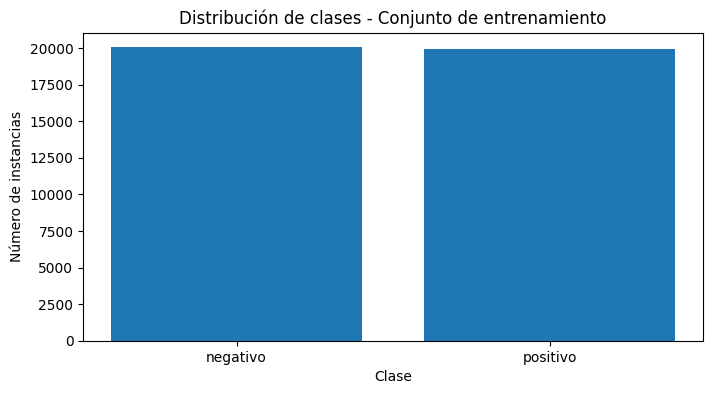

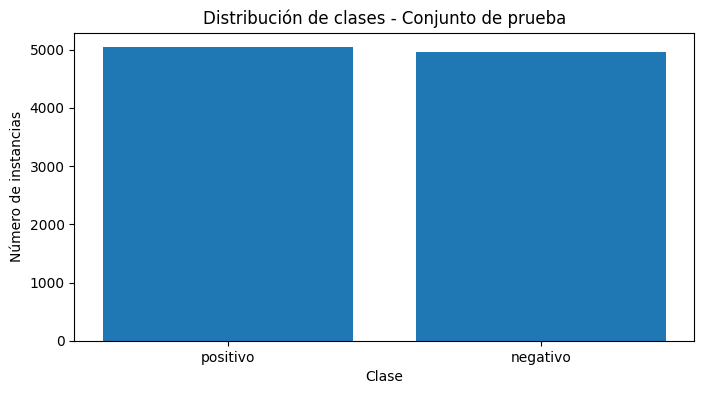

In [ ]:
import matplotlib.pyplot as plt

train_class_counts = pd.Series(y_train).value_counts()
test_class_counts = pd.Series(y_test).value_counts()

# Visualización del conjunto de entrenamiento
plt.figure(figsize=(8, 4))
plt.bar(train_class_counts.index, train_class_counts.values)
plt.title('Distribución de clases - Conjunto de entrenamiento')
plt.xlabel('Clase')
plt.ylabel('Número de instancias')
plt.show()

# Visualización del conjunto de prueba
plt.figure(figsize=(8, 4))
plt.bar(test_class_counts.index, test_class_counts.values)
plt.title('Distribución de clases - Conjunto de prueba')
plt.xlabel('Clase')
plt.ylabel('Número de instancias')
plt.show()

# Modelo 1: Bayes Naïve con CountVectorizer

Como primer modelo vamos a probar Bayes Naïve tokenizando con CountVectorizer y eliminando las stopwords. Usaremos un clasificador multinomial y técnica de Laplace Smoothing con alpha = 1.

In [ ]:
modelo = make_pipeline(CountVectorizer(stop_words=stopwords), MultinomialNB(alpha=1))
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

Observamos que las métricas dan todas similares, cercanas al 83%.

La accuracy es 0.8366
La precision es 0.8383409388641156
El recall es 0.8368786756986295
El F1 es 0.8364605597316497


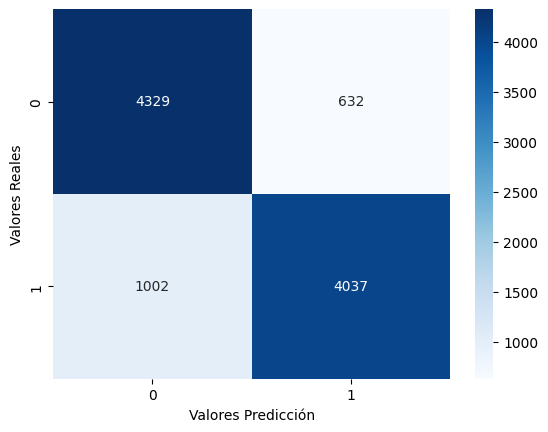

In [ ]:
mostrar_metricas(y_test, y_pred)

Observación: este modelo overfitteó. Obtuvimos buenas métricas en entrenamiento, pero malas métricas en la submission de Kaggle.

# Modelo 2: Bayes Naïve con TfidfVectorizer

Vamos a entrenar un segundo modelo Bayes Naïve, esta vez utilizando valores normalizados, computando la frecuencia inversa de cada término con TfidfVectorizer.

In [ ]:
modelo_2 = make_pipeline(TfidfVectorizer(stop_words=stopwords), MultinomialNB(alpha=0.5))

modelo_2.fit(X_train, y_train)

y_pred = modelo_2.predict(X_test)

Observando las métricas, estas dieron un poco más altas que con CountVectorizer, cercanas al 85%.

La accuracy es 0.8526
La precision es 0.8526173362564071
El recall es 0.8526347142960178
El F1 es 0.8525992865805472


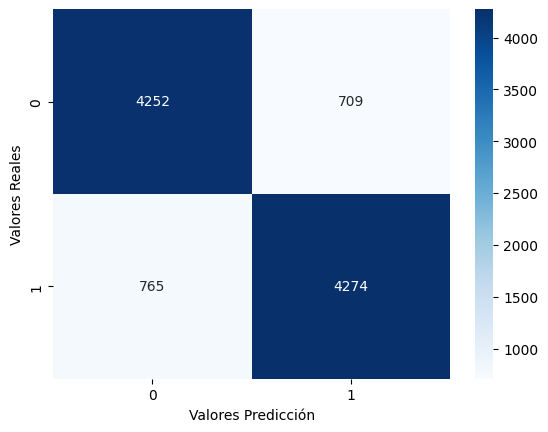

In [ ]:
mostrar_metricas(y_test, y_pred)

Nota: este modelo también overfitteó al hacer las predicciones en Kaggle (dio 85% en train y 71% en test, aproximadamente).

## Optimización de hiperparámetros

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

parametros = {
    'multinomialnb__alpha': np.arange(0, 1.2, 0.2),
    'multinomialnb__fit_prior': [True, False]
}

pipeline = make_pipeline(TfidfVectorizer(stop_words=stopwords), MultinomialNB())

grid_search = GridSearchCV(pipeline, parametros, scoring='f1', cv=7)

grid_search.fit(X_train, y_train)

mejores_parametros = grid_search.best_params_
mejor_puntaje = grid_search.best_score_
mejor_modelo = grid_search.best_estimator_

print(f"Mejores parametros: {mejores_parametros}")
print(f"Mejor puntaje: {mejor_puntaje}")

C:\Users\camila.bartocci.GLOBALAD\AppData\Roaming\Python\Python311\site-packages\sklearn\naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
C:\Users\camila.bartocci.GLOBALAD\AppData\Roaming\Python\Python311\site-packages\sklearn\naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
C:\Users\camila.bartocci.GLOBALAD\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\camila.bartocci.GLOBALAD\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test,

Mejores parametros: {'multinomialnb__alpha': 0.0, 'multinomialnb__fit_prior': True}
Mejor puntaje: nan


C:\Users\camila.bartocci.GLOBALAD\AppData\Roaming\Python\Python311\site-packages\sklearn\naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
C:\Users\camila.bartocci.GLOBALAD\AppData\Roaming\Python\Python311\site-packages\sklearn\naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


La accuracy es 0.7712
La precision es 0.7712318934618081
El recall es 0.7711377160186426
El F1 es 0.7711551464086961


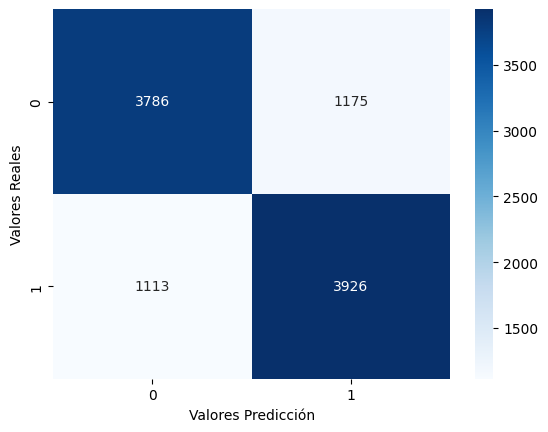

In [ ]:
y_pred = mejor_modelo.predict(X_test)
mostrar_metricas(y_test, y_pred)

Observación: optimizamos hiperparámetros para el dataset radicalizado, lematizado y sin preprocesamientos, y no obtuvimos muy buenos resultados. Los tres modelos sobreajustaron. 

# Random Forest (optimización con Random Search)

Empezamos creando un modelo Random Forest por default y observamos las métricas obtenidas

In [ ]:
modelo_rf = make_pipeline(TfidfVectorizer(stop_words=stopwords), RandomForestClassifier())

modelo_rf.fit(X_train, y_train)

y_pred = modelo_2.predict(X_test)

La accuracy es 0.8526
La precision es 0.8526173362564071
El recall es 0.8526347142960178
El F1 es 0.8525992865805472


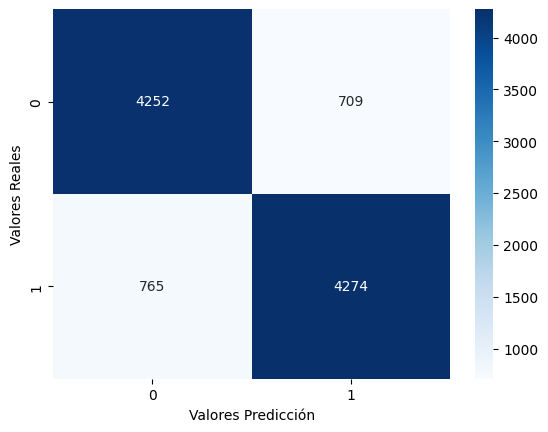

In [ ]:
mostrar_metricas(y_test, y_pred)

Aplicamos Random Search para buscar los mejores hiperparámetros de un modelo Random Forest.
Nota: vamos a estar realizando de a 10 iteraciones por búsqueda para llegar a resultados, intentando con Grid Search tardó demasiado y no logramos terminar de correrlo. 

C:\Users\camila.bartocci.GLOBALAD\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\camila.bartocci.GLOBALAD\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\camila.bartocci.GLOBALAD\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
           ^^^^^^^^^^^^
  File "C:\Users\camila.bartocci.GLOBALAD\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  Fil

La accuracy es 0.8224
La precision es 0.8235754985382965
El recall es 0.8221598602058949
El F1 es 0.8221538894383604


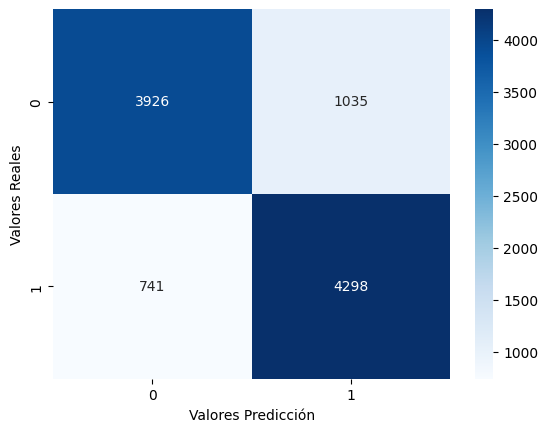

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import RandomizedSearchCV

# parametros = {
#     'n_estimators': [60, 80, 100, 150, 200],
#     'max_depth': [5, 10, 15, 20],
#     'min_samples_split': [2, 5, 7, 10],
#     'min_samples_leaf': [1, 2, 4],
# }

# modelo_rf_random_search = make_pipeline(TfidfVectorizer(stop_words=stopwords), RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=parametros, scoring='f1', n_iter=10, cv=7))

# modelo_rf_random_search.fit(X_train, y_train)

# mejores_parametros = modelo_rf_random_search.best_params_
# mejor_puntaje = modelo_rf_random_search.best_score_

# mejor_modelo = modelo_rf_random_search.best_estimator_

# mejor_modelo.score(X_test, y_test)

from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Definir los hiperparámetros a considerar en la búsqueda aleatoria
parametros = {
    'randomforestclassifier__n_estimators': randint(80, 150),
    'randomforestclassifier__max_depth': [5, 10, 15],
    'randomforestclassifier__min_samples_split': randint(2, 10),
    'randomforestclassifier__min_samples_leaf': randint(1, 4),
}

# Crear el pipeline con el vectorizador TF-IDF y el clasificador Random Forest
pipeline = make_pipeline(
    TfidfVectorizer(stop_words=stopwords),
    RandomForestClassifier()
)

# Realizar la búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(
    pipeline,
    parametros,
    scoring='f1',
    n_iter=10,
    cv=5,
    random_state=42
)

# Entrenar el modelo con la búsqueda aleatoria de hiperparámetros
random_search.fit(X_train, y_train)

# Obtener el mejor modelo y los mejores parámetros
mejor_modelo = random_search.best_estimator_
mejores_parametros = random_search.best_params_

# Evaluar el mejor modelo en el conjunto de prueba
y_pred = mejor_modelo.predict(X_test)


Analizamos las métricas del mejor modelo obtenido en esta iteración.

La accuracy es 0.8224
La precision es 0.8235754985382965
El recall es 0.8221598602058949
El F1 es 0.8221538894383604


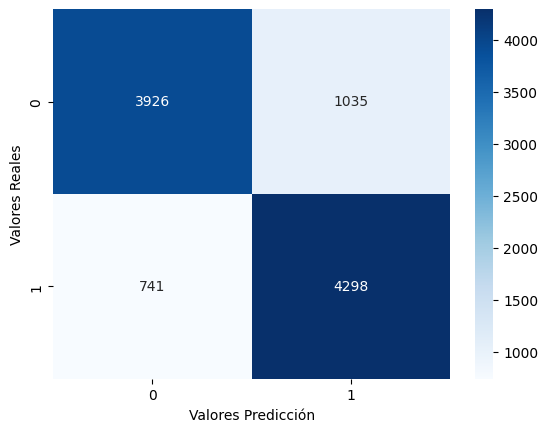

In [ ]:
mostrar_metricas(y_test, y_pred)

Obtenemos la mejor combinación de hiperparámetros lograda en esta iteración.

In [ ]:
mejores_parametros

{'randomforestclassifier__max_depth': 15,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 8,
 'randomforestclassifier__n_estimators': 140}

In [ ]:
# import pickle

# with open('./models/random_forest/rf_model3.pickle', 'wb') as archivo:
#     pickle.dump(mejor_modelo, archivo)

In [ ]:
# with open('./models/random_forest/rf_model3.pickle', 'rb') as archivo:
#     modelo_cargado = pickle.load(archivo)

# ds_test = pd.read_csv('./test_normalizado_lematizacion.csv')
# ds_submission = ds_test.copy()

# nuevas_caracteristicas = vectorizador.transform(ds_submission.review_es)
# predicciones_nuevas = modelo_cargado.predict(nuevas_caracteristicas)

# df_submission = pd.DataFrame({'ID': ds_submission.ID, 'sentimiento': predicciones_nuevas})
# df_submission.head()
# df_submission.to_csv('submissions/random_forest/rf_submission3.csv', index=False)

La mejor que obtuvimos de 2: 82% aprox. todo en entrenamiento, 72% en test con el dataset original y con 
{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 20}

Estas son las metricas de ese modelo en train, es el que es 0.72804 en kaggle:
La accuracy es 0.8205
La precision es 0.8216906233847056
El recall es 0.8202574044604873
El F1 es 0.8202472226568611

# XGBoost


Utilizamos LabelEncoder para convertir y_train e y_test en un vector numerico, siendo 0 equivalente a negativo y 1 a positivo, y asi poder hacer un modelo XGBoost

In [10]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
y_train_tranf= label_encoder.fit_transform(y_train)
y_test_tranf= label_encoder.fit_transform(y_test)



In [11]:
modelo_xgb = make_pipeline(TfidfVectorizer(stop_words=stopwords), xgb.XGBClassifier())

modelo_xgb.fit(X_train, y_train_tranf)

y_pred = modelo_xgb.predict(X_test)

La accuracy es 0.8378
La precision es 0.8382279453953125
El recall es 0.8376575230837044
El F1 es 0.8377001791181649


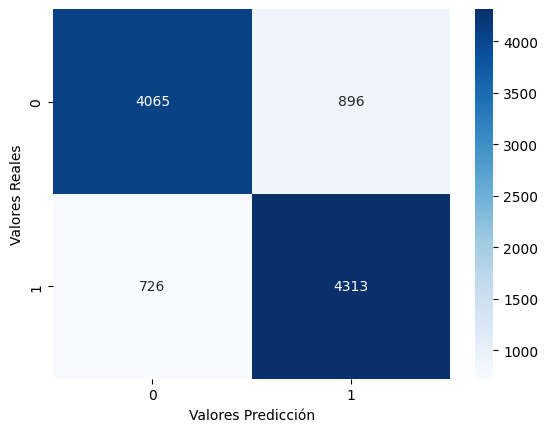

In [12]:
mostrar_metricas(y_test_tranf, y_pred)

Transformo los 0 y 1 en negativo y positivo respectivamente.

In [13]:
y_pred_xgb_tranf = label_encoder.inverse_transform(y_pred)

## Optimización de hiperparámetros

Aplicamos Random Search para buscar los mejores hiperparámetros de un modelo XGBoost Classifier.

In [22]:
params = {
    'xgbclassifier__learning_rate':    [0.05, 0.3],
    'xgbclassifier__max_depth':        [5, 16, 5], 
    'xgbclassifier__min_child_weight': [1, 10, 1], 
    'xgbclassifier__colsample_bytree': [0.3, 1], 
    'xgbclassifier__subsample':        [0.4, 1], 
    'xgbclassifier__n_estimators':     [5, 10, 15, 20],
    'xgbclassifier__reg_alpha':        [0, 0.001, 0.005, 0.01, 0.05], 
    'xgbclassifier__gamma':            [0, 0.005, 0.01, 0.05, 1]
}
pipeline= make_pipeline(TfidfVectorizer(stop_words=stopwords), xgb.XGBClassifier())
random_search=   RandomizedSearchCV(pipeline, params,scoring="f1",cv=5)
random_search.fit(X_train, y_train_tranf)


#Obtenemos el mejor modelo y los mejores parámetros
mejor_modelo_xgb_cv = random_search.best_estimator_
mejores_parametros_xgb_cv = random_search.best_params_

In [24]:
# Evaluar el mejor modelo en el conjunto de prueba
y_pred_xgb_cv = mejor_modelo_xgb_cv.predict(X_test)

Analizamos las métricas del mejor modelo obtenido.

La accuracy es 0.8
La precision es 0.8009216376686781
El recall es 0.799775658351054
El F1 es 0.799754699506896


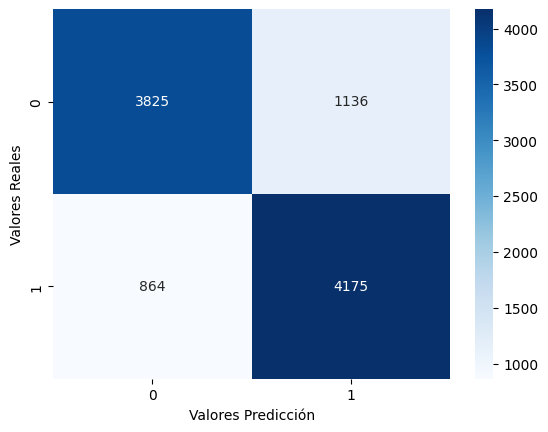

In [25]:
mostrar_metricas(y_test_tranf, y_pred_xgb_cv)

Obtenemos la mejor combinación de hiperparámetros lograda.

In [23]:
mejores_parametros_xgb_cv

{'xgbclassifier__subsample': 1,
 'xgbclassifier__reg_alpha': 0.005,
 'xgbclassifier__n_estimators': 20,
 'xgbclassifier__min_child_weight': 1,
 'xgbclassifier__max_depth': 16,
 'xgbclassifier__learning_rate': 0.05,
 'xgbclassifier__gamma': 0.05,
 'xgbclassifier__colsample_bytree': 0.3}

Transformo los 0 y 1 en negativo y positivo respectivamente.

In [30]:

y_pred_xgb_cv_tranf = label_encoder.inverse_transform(y_pred_xgb_cv)


Conseguimos mejores resultados con el modelo xgboost sin optimizar los parametros. Los resultados obtenidos fueron una precision de 0.84 y un F1 de 0.84

In [14]:
import pickle

with open('./models/xgboost/xgb_model_1.pickle', 'wb') as archivo:
    pickle.dump(modelo_xgb, archivo)

In [19]:
"""
Falta corregir esto para armar el csv
with open('./models/xgboost/xgb_model_1.pickle', 'rb') as archivo:
    modelo_cargado = pickle.load(archivo)

ds_test = pd.read_csv('./test_normalizado_lematizacion.csv')
ds_submission = ds_test.copy()

nuevas_caracteristicas = vectorizador.transform(ds_submission.review_es)
predicciones_nuevas = modelo_cargado.predict(nuevas_caracteristicas)

df_submission = pd.DataFrame({'ID': ds_submission.ID, 'sentimiento': predicciones_nuevas})
df_submission.head()
df_submission.to_csv('submissions/xgboost/xgb_model_1.csv', index=False)

"""

"\nFalta corregir esto para armar el csv\nwith open('./models/xgboost/xgb_model_1.pickle', 'rb') as archivo:\n    modelo_cargado = pickle.load(archivo)\n\nds_test = pd.read_csv('./test_normalizado_lematizacion.csv')\nds_submission = ds_test.copy()\n\nnuevas_caracteristicas = vectorizador.transform(ds_submission.review_es)\npredicciones_nuevas = modelo_cargado.predict(nuevas_caracteristicas)\n\ndf_submission = pd.DataFrame({'ID': ds_submission.ID, 'sentimiento': predicciones_nuevas})\ndf_submission.head()\ndf_submission.to_csv('submissions/xgboost/xgb_model_1.csv', index=False)\n\n"